# Image Classification Challenge — ResNet vs MobileNet (PyTorch)
This notebook compares **ResNet18** and **MobileNetV2** on the **CIFAR-10** dataset using PyTorch.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import time


## 1.Dataset Selection & Preprocessing

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


## 2.Data visualization

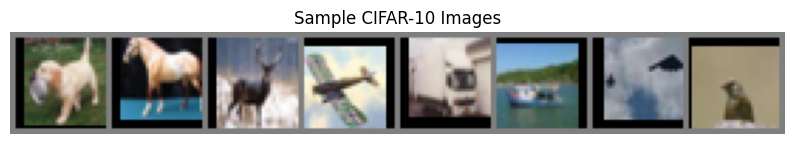

dog      horse    deer     plane    truck    ship     plane    bird    


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 5))
imshow(torchvision.utils.make_grid(images[:8]))
plt.title('Sample CIFAR-10 Images')
plt.show()
print(' '.join(f'{classes[labels[j]]:8s}' for j in range(8)))


## 3.Define Models — ResNet18 & MobileNetV2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

mobilenet = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
mobilenet = mobilenet.to(device)

models = {'ResNet18': resnet, 'MobileNetV2': mobilenet}


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 217MB/s]


## 4.Training & Evaluation Functions

In [5]:
criterion = nn.CrossEntropyLoss()

def train_model(model, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}')

def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = 100 * correct / total
    print(classification_report(y_true, y_pred, target_names=classes))
    return acc


## 5️.Train & Compare Models

In [6]:
results = {}
for name, model in models.items():
    print(f'\n🔹 Training {name}...')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    start_time = time.time()
    train_model(model, optimizer, epochs=5)
    acc = evaluate_model(model)
    elapsed = time.time() - start_time
    results[name] = {'accuracy': acc, 'time': elapsed}
    print(f'{name} - Accuracy: {acc:.2f}% | Time: {elapsed:.1f}s')



🔹 Training ResNet18...
Epoch [1/5] - Loss: 1.1129
Epoch [2/5] - Loss: 0.8329
Epoch [3/5] - Loss: 0.7227
Epoch [4/5] - Loss: 0.6553
Epoch [5/5] - Loss: 0.6245
              precision    recall  f1-score   support

       plane       0.71      0.84      0.77      1000
         car       0.90      0.88      0.89      1000
        bird       0.82      0.62      0.70      1000
         cat       0.66      0.58      0.62      1000
        deer       0.85      0.65      0.74      1000
         dog       0.73      0.70      0.72      1000
        frog       0.87      0.81      0.84      1000
       horse       0.69      0.90      0.78      1000
        ship       0.83      0.92      0.87      1000
       truck       0.80      0.89      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

ResNet18 - Accuracy: 77.91% | Time: 190.2s

🔹 Training MobileNetV2...
Epoch [1/5] 

In [7]:
#results summary
for name, info in results.items():
    print(f'{name}: Accuracy = {info["accuracy"]:.2f}% | Time = {info["time"]:.1f}s')


ResNet18: Accuracy = 77.91% | Time = 190.2s
MobileNetV2: Accuracy = 67.45% | Time = 193.0s


## 6.Evaluation

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
def evaluate_model(model, dataloader, device, classes):
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_time = time.time() - start_time
    report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

    # Confusion Matrix (← correctly indented now)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return report, total_time


🔹 Evaluating ResNet18:
Classification Report:
               precision    recall  f1-score   support

       plane       0.71      0.84      0.77      1000
         car       0.90      0.88      0.89      1000
        bird       0.82      0.62      0.70      1000
         cat       0.66      0.58      0.62      1000
        deer       0.85      0.65      0.74      1000
         dog       0.73      0.70      0.72      1000
        frog       0.87      0.81      0.84      1000
       horse       0.69      0.90      0.78      1000
        ship       0.83      0.92      0.87      1000
       truck       0.80      0.89      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



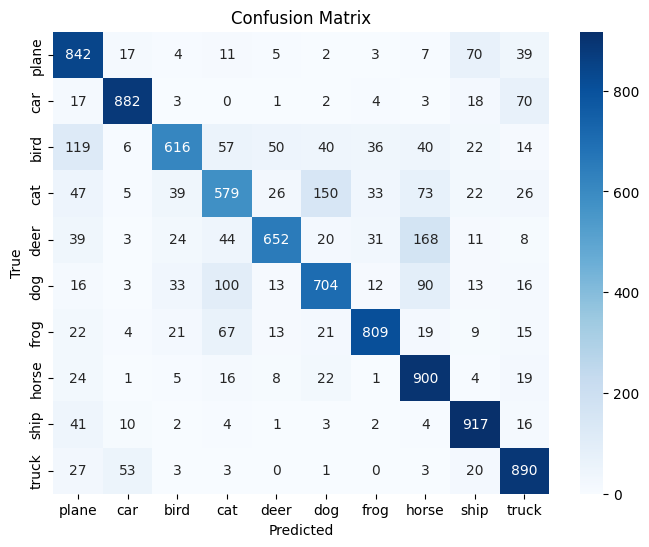


🔹 Evaluating MobileNetV2:
Classification Report:
               precision    recall  f1-score   support

       plane       0.67      0.69      0.68      1000
         car       0.89      0.59      0.71      1000
        bird       0.62      0.64      0.63      1000
         cat       0.63      0.31      0.42      1000
        deer       0.66      0.67      0.66      1000
         dog       0.50      0.76      0.61      1000
        frog       0.76      0.80      0.78      1000
       horse       0.72      0.77      0.74      1000
        ship       0.70      0.81      0.75      1000
       truck       0.72      0.72      0.72      1000

    accuracy                           0.67     10000
   macro avg       0.69      0.67      0.67     10000
weighted avg       0.69      0.67      0.67     10000



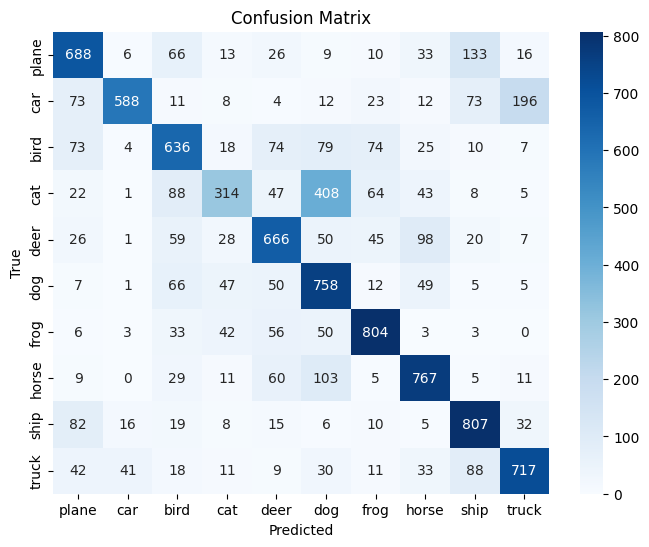


Summary of Model Evaluation:
ResNet18: Accuracy = 0.7791, Inference Time = 3.56s
MobileNetV2: Accuracy = 0.6745, Inference Time = 3.68s


In [13]:
# Evaluate each model
results = {}

for name, model in models.items():
    print(f"\n🔹 Evaluating {name}:")
    report, eval_time = evaluate_model(model, testloader, device, classes)
    results[name] = {
        'report': report,
        'eval_time': eval_time
    }

# Summarize results
print("\nSummary of Model Evaluation:")
for name, info in results.items():
    accuracy = info['report']['accuracy']
    print(f"{name}: Accuracy = {accuracy:.4f}, Inference Time = {info['eval_time']:.2f}s")


## 7.Models Compararison

In [16]:
import pandas as pd

# Prepare data for comparison dynamically from results dictionary
comparison_data = {
    "Model": [],
    "Accuracy": [],
    "F1-score": [],
    "Precision": [],
    "Recall": [],
    "Inference Time (s)": []
}

# Loop through evaluated models
for name, info in results.items():
    report = info['report']
    comparison_data["Model"].append(name)
    comparison_data["Accuracy"].append(report['accuracy'])
    comparison_data["F1-score"].append(report['macro avg']['f1-score'])
    comparison_data["Precision"].append(report['macro avg']['precision'])
    comparison_data["Recall"].append(report['macro avg']['recall'])
    comparison_data["Inference Time (s)"].append(info['eval_time'])

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


,Model,Accuracy,F1-score,Precision,Recall,Inference Time (s)
0,ResNet18,0.7791,0.776136,0.784378,0.7791,3.559849
1,MobileNetV2,0.6745,0.669375,0.687082,0.6745,3.679851


## 8. Visualisation

In [20]:
# filter visualization function
def visualize_filters(model, model_name):
    """Visualize the first convolutional layer filters of a CNN."""
    print(f"\nVisualizing filters of {model_name}...")

    # Find the first conv layer
    first_conv = None
    for layer in model.modules():
        if isinstance(layer, torch.nn.Conv2d):
            first_conv = layer
            break

    if first_conv is None:
        print(f"No Conv2d layer found in {model_name}")
        return

    # Get weights and move to CPU
    weights = first_conv.weight.data.cpu()
    num_filters = min(weights.shape[0], 32)  # show up to 32 filters

    plt.figure(figsize=(12, 6))
    for i in range(num_filters):
        plt.subplot(4, 8, i+1)
        w = weights[i]
        w = (w - w.min()) / (w.max() - w.min())  # normalize for display
        plt.imshow(np.transpose(w.numpy(), (1, 2, 0)))
        plt.axis("off")
    plt.suptitle(f"{model_name} - First Convolutional Filters")
    plt.show()

In [21]:
def visualize_activation(model, model_name, image, layer_index=0):
    """Visualize activation maps for one image from a chosen convolutional layer."""
    print(f"\nVisualizing activations for {model_name}...")

    activations = []
    def hook_fn(module, input, output):
        activations.append(output)

    # Register hook to capture outputs of a conv layer
    conv_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d)]
    if not conv_layers:
        print(f"No Conv2d layers found in {model_name}")
        return

    handle = conv_layers[layer_index].register_forward_hook(hook_fn)

    # Run one image through the model
    model.eval()
    with torch.no_grad():
        _ = model(image.unsqueeze(0))  # add batch dimension

    handle.remove()

    # Get activation map
    act = activations[0].squeeze().cpu()
    num_maps = min(act.shape[0], 16)

    plt.figure(figsize=(10, 6))
    for i in range(num_maps):
        plt.subplot(4, 4, i + 1)
        plt.imshow(act[i], cmap="viridis")
        plt.axis("off")
    plt.suptitle(f"{model_name} - Activation Maps (Layer {layer_index})")
    plt.show()



Visualizing filters of ResNet18...


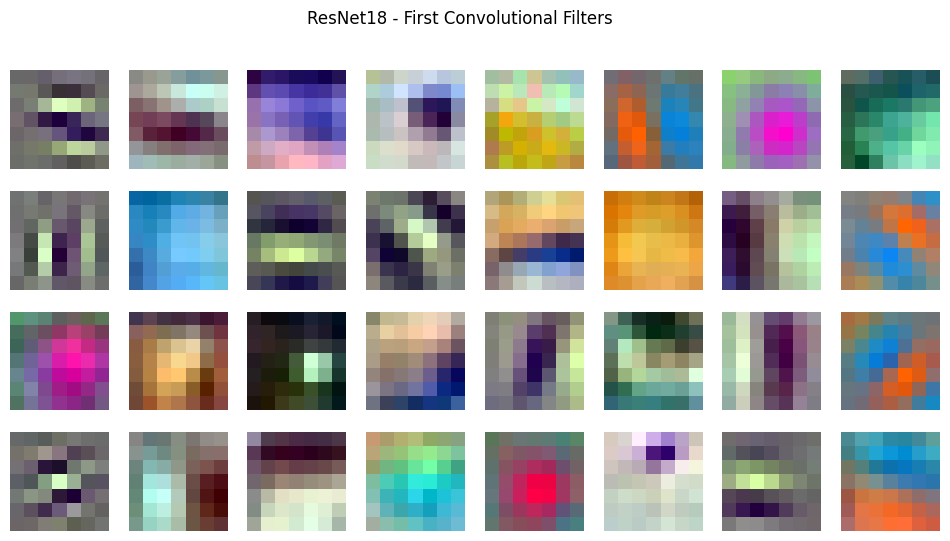


Visualizing activations for ResNet18...


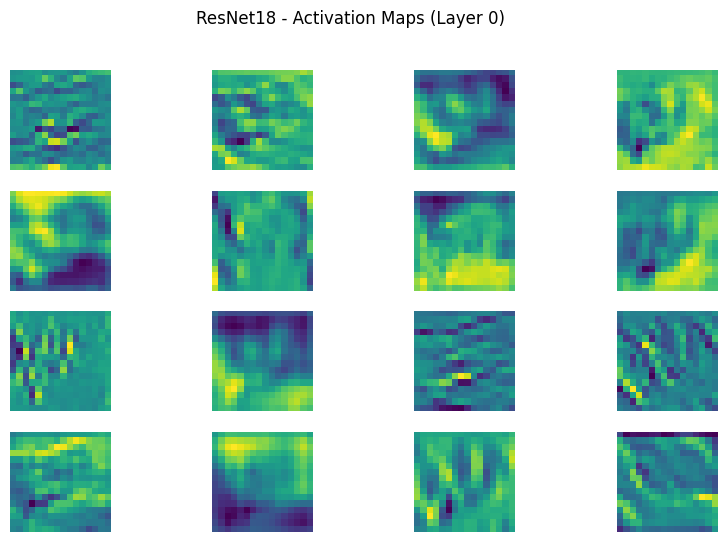


Visualizing filters of MobileNetV2...


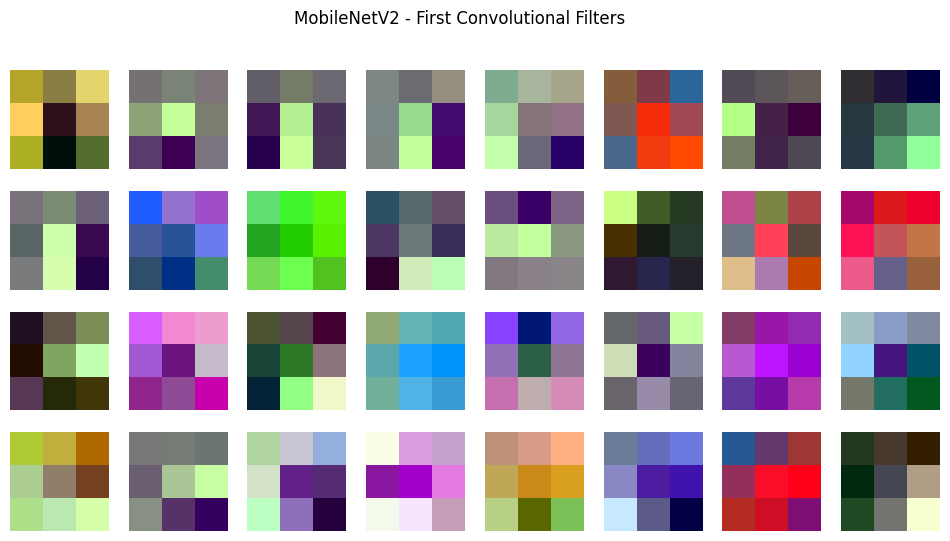


Visualizing activations for MobileNetV2...


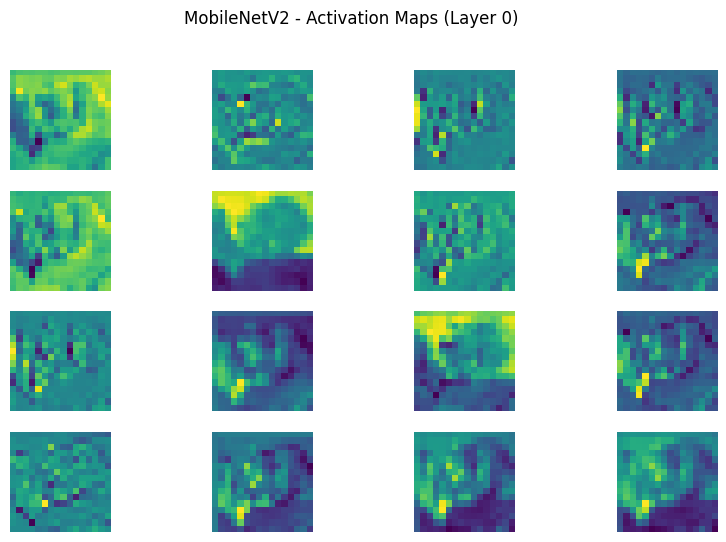

In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)
image = images[0].to(device)

# Loop over models
for name, model in models.items():
    visualize_filters(model, name)
    visualize_activation(model, name, image)